In [191]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from prettytable import PrettyTable
from collections import Counter
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\elena\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\elena\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Data Preprocessing

In [192]:
# Loading the data and bringing it to form.
paths={
    'train':'train.tsv',
    'test':'test.tsv',
    'valid':'valid.tsv'
    }

titles=['ID','label','statement','subject','speaker','job_title','state_info','party_affiliation','barely_true_counts','false_counts','half_true_counts','mostly_true_counts','pants_on_fire_counts','context']

df=pd.DataFrame(columns=titles)
for path in paths.values():
    df_temp=pd.read_csv(path,sep='\t',header=None,names=titles)
    df=pd.concat([df,df_temp],ignore_index=True)

df.head()

C:\Users\elena\AppData\Local\Temp\ipykernel_23820\413566240.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df=pd.concat([df,df_temp],ignore_index=True)


,ID,label,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [193]:
#Check dataset
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12791 entries, 0 to 12790
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    12791 non-null  object 
 1   label                 12791 non-null  object 
 2   statement             12791 non-null  object 
 3   subject               12789 non-null  object 
 4   speaker               12789 non-null  object 
 5   job_title             9223 non-null   object 
 6   state_info            10040 non-null  object 
 7   party_affiliation     12789 non-null  object 
 8   barely_true_counts    12789 non-null  float64
 9   false_counts          12789 non-null  float64
 10  half_true_counts      12789 non-null  float64
 11  mostly_true_counts    12789 non-null  float64
 12  pants_on_fire_counts  12789 non-null  float64
 13  context               12660 non-null  object 
dtypes: float64(5), object(9)
memory usage: 1.4+ MB
None
       barely_true

In [194]:
# check for missing values
print(df.isnull().sum())

ID                         0
label                      0
statement                  0
subject                    2
speaker                    2
job_title               3568
state_info              2751
party_affiliation          2
barely_true_counts         2
false_counts               2
half_true_counts           2
mostly_true_counts         2
pants_on_fire_counts       2
context                  131
dtype: int64


In [195]:
#Removing the rows that contain 2 missing values
df = df.dropna(subset=['subject', 'speaker'])
print(df.isnull().sum())

ID                         0
label                      0
statement                  0
subject                    0
speaker                    0
job_title               3566
state_info              2749
party_affiliation          0
barely_true_counts         0
false_counts               0
half_true_counts           0
mostly_true_counts         0
pants_on_fire_counts       0
context                  129
dtype: int64


In [196]:
#Checking the percentage of the rest of the missing values
miss_perc = (df.isnull().mean() * 100).round(2)
miss_perc

ID                       0.00
label                    0.00
statement                0.00
subject                  0.00
speaker                  0.00
job_title               27.88
state_info              21.50
party_affiliation        0.00
barely_true_counts       0.00
false_counts             0.00
half_true_counts         0.00
mostly_true_counts       0.00
pants_on_fire_counts     0.00
context                  1.01
dtype: float64

In [197]:
#Next we replace the rest of the missing values with "Unknown"
df['job_title'] = df['job_title'].fillna('Unknown')
df['state_info'] = df['state_info'].fillna('Unknown')
df['context'] = df['context'].fillna('Unknown')

In [198]:
df.isnull().sum()

ID                      0
label                   0
statement               0
subject                 0
speaker                 0
job_title               0
state_info              0
party_affiliation       0
barely_true_counts      0
false_counts            0
half_true_counts        0
mostly_true_counts      0
pants_on_fire_counts    0
context                 0
dtype: int64

In [199]:
# We create a new column that defines a binary mapping of the multilabel column. 1 is fake news and 0 is real news.
binary_label_map = {
    'true': 0,
    'mostly-true': 0,
    'half-true': 0,
    'barely-true': 1,
    'false': 1,
    'pants-fire': 1
}


df['label_binary'] = df['label'].map(binary_label_map)


df['label_binary'].value_counts()

label_binary
0    7134
1    5655
Name: count, dtype: int64

In [200]:
label_mapping = {
    'pants-fire': 1,
    'false': 2,
    'barely-true': 3,
    'half-true': 4,
    'mostly-true': 5,
    'true': 6}

df['m_label'] = df['label'].replace(label_mapping)

C:\Users\elena\AppData\Local\Temp\ipykernel_23820\779568377.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['m_label'] = df['label'].replace(label_mapping)


In [201]:
df

,ID,label,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,label_binary,m_label
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,1,2
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,0,4
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,0,5
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,Unknown,Unknown,none,7.0,19.0,3.0,5.0,44.0,a news release,1,2
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,Unknown,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12786,3419.json,half-true,"For the first time in more than a decade, impo...","energy,oil-spill,trade",barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,a press conference,0,4
12787,12548.json,mostly-true,Says Donald Trump has bankrupted his companies...,candidates-biography,hillary-clinton,Presidential candidate,New York,democrat,40.0,29.0,69.0,76.0,7.0,a speech on the economy,0,5
12788,401.json,true,"John McCain and George Bush have ""absolutely n...",health-care,campaign-defend-america,Unknown,"Washington, D.C.",none,0.0,1.0,0.0,2.0,0.0,a television ad,0,6
12789,1055.json,false,A new poll shows 62 percent support the presid...,health-care,americans-united-change,Unknown,Unknown,none,1.0,4.0,4.0,1.0,0.0,an Internet ad.,1,2


In [202]:
#  Changing types to proper format
df['barely_true_counts'] = df['barely_true_counts'].astype(int)
df['false_counts'] = df['false_counts'].astype(int)
df['half_true_counts'] = df['half_true_counts'].astype(int)
df['mostly_true_counts'] = df['mostly_true_counts'].astype(int)
df['pants_on_fire_counts'] = df['pants_on_fire_counts'].astype(int)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12789 entries, 0 to 12790
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID                    12789 non-null  object
 1   label                 12789 non-null  object
 2   statement             12789 non-null  object
 3   subject               12789 non-null  object
 4   speaker               12789 non-null  object
 5   job_title             12789 non-null  object
 6   state_info            12789 non-null  object
 7   party_affiliation     12789 non-null  object
 8   barely_true_counts    12789 non-null  int64 
 9   false_counts          12789 non-null  int64 
 10  half_true_counts      12789 non-null  int64 
 11  mostly_true_counts    12789 non-null  int64 
 12  pants_on_fire_counts  12789 non-null  int64 
 13  context               12789 non-null  object
 14  label_binary          12789 non-null  int64 
 15  m_label               12789 non-null  int

In [203]:
# Checking party affiliation distribution
df['party_affiliation'].value_counts()

party_affiliation
republican                      5665
democrat                        4137
none                            2181
organization                     264
independent                      180
newsmaker                         64
libertarian                       51
journalist                        49
activist                          45
columnist                         44
talk-show-host                    32
state-official                    24
labor-leader                      15
business-leader                   11
tea-party-member                  10
education-official                 3
green                              3
constitution-party                 3
county-commissioner                2
government-body                    2
Moderate                           1
liberal-party-canada               1
ocean-state-tea-party-action       1
democratic-farmer-labor            1
Name: count, dtype: int64

In [204]:
# Replacing 'none' with 'no affiliation' & dropping rest values
df['party_affiliation'].unique()

df.drop(df[df['party_affiliation'].isin(['democrat','republican','none'])==False].index, inplace=True)

df['party_affiliation'] = df['party_affiliation'].replace('none', 'no affiliation')



Exploratory Data Analysis (EDA)

(array([0, 1, 2]),
 [Text(0, 0, 'republican'),
  Text(1, 0, 'democrat'),
  Text(2, 0, 'no affiliation')])

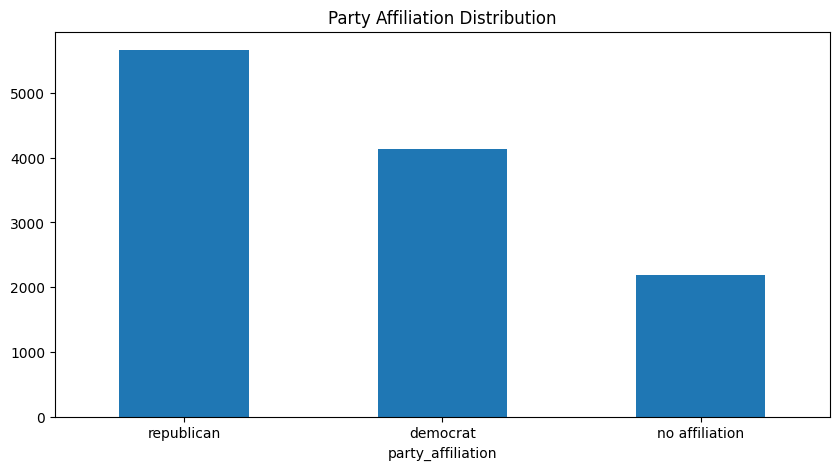

In [205]:
#Checking if the 'party_affiliation' changes worked
df['party_affiliation'].value_counts().plot(kind='bar', figsize=(10, 5))
plt.title('Party Affiliation Distribution')
plt.xticks(rotation=0)

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'half-true'),
  Text(1, 0, 'false'),
  Text(2, 0, 'mostly-true'),
  Text(3, 0, 'barely-true'),
  Text(4, 0, 'true'),
  Text(5, 0, 'pants-fire')])

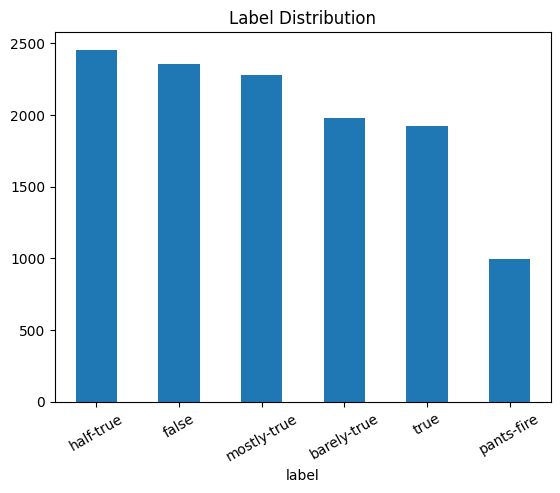

In [206]:
# Distribution of labels
df['label'].value_counts().plot(kind='bar')
plt.title('Label Distribution')
plt.xticks(rotation=30)

Text(0, 0.5, 'Count')

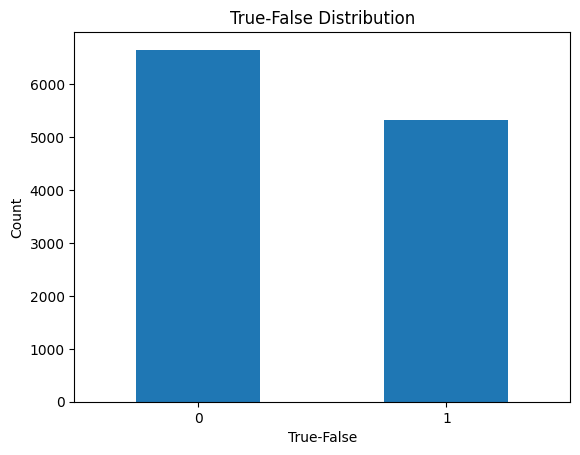

In [207]:
df['label_binary'].value_counts().plot(kind='bar')
plt.title('True-False Distribution')
plt.xticks(rotation=0, ha='center')
plt.xlabel('True-False')
plt.ylabel('Count')

In [208]:
# Checking length of statements
df['statement'].str.len().describe()

count    11983.000000
mean       107.037553
std         64.471012
min         11.000000
25%         73.000000
50%         98.000000
75%        133.000000
max       3192.000000
Name: statement, dtype: float64

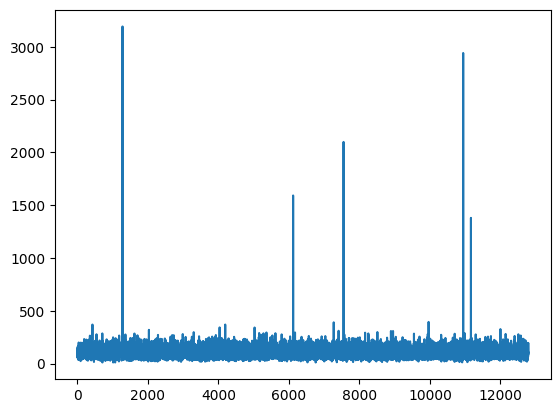

In [209]:
statement_length = df['statement'].apply(len)
statement_length.plot()
plt.show()

In [210]:
# Clearing outliers 
Q1 = statement_length.quantile(0.25)
Q3 = statement_length.quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5 * IQR

df = df[statement_length < upper_bound]
statement_length = statement_length[statement_length < upper_bound]

In [211]:
statement_length.describe()


count    11783.000000
mean       103.742001
std         41.282072
min         11.000000
25%         73.000000
50%         98.000000
75%        131.000000
max        222.000000
Name: statement, dtype: float64

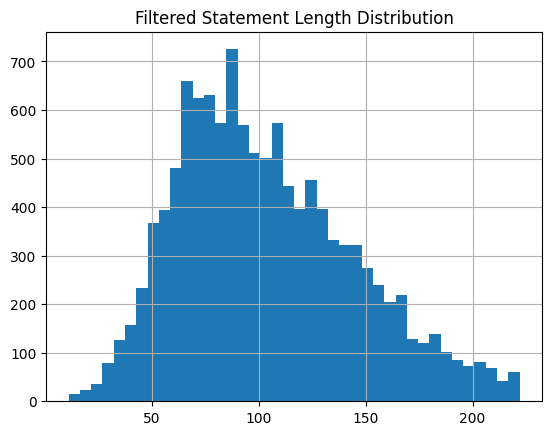

In [212]:
statement_length.hist(bins=40)
plt.title("Filtered Statement Length Distribution")
plt.show()

In [213]:
df['speaker'].value_counts()

speaker
barack-obama       606
donald-trump       339
hillary-clinton    289
mitt-romney        211
john-mccain        187
                  ... 
alan-essig           1
vincent-prieto       1
bill-mcraven         1
rebecca-blank        1
john-whitmire        1
Name: count, Length: 2855, dtype: int64

<Axes: ylabel='job_title'>

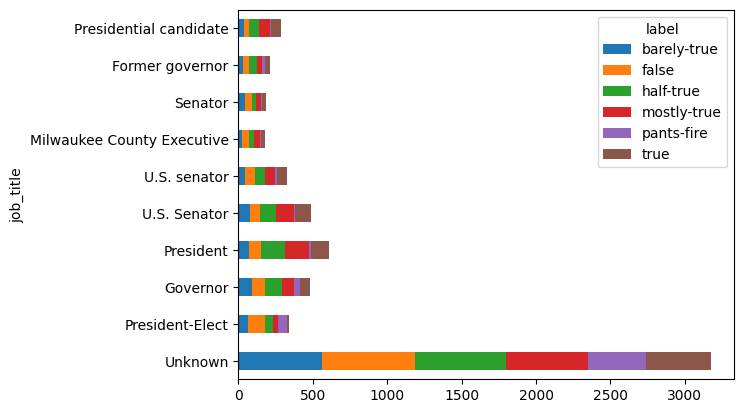

In [214]:
pd.crosstab(df['job_title'], df['label']).sort_values(by='false', ascending=False).head(10).plot(kind='barh', stacked=True)

<Axes: ylabel='job_title'>

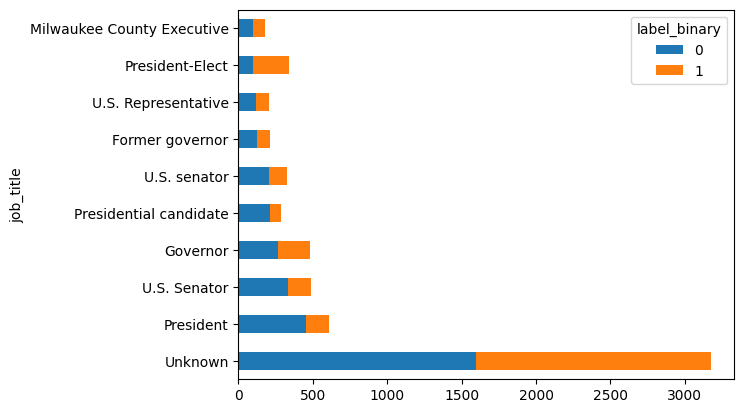

In [215]:
pd.crosstab(df['job_title'], df['label_binary']).sort_values(by=0, ascending=False).head(10).plot(kind='barh', stacked=True)

<Axes: title={'center': 'Party-wise Label Distribution'}, xlabel='party_affiliation'>

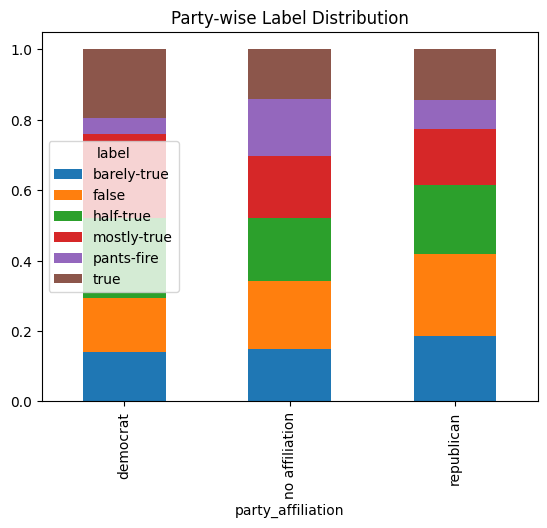

In [216]:
df.groupby('party_affiliation')['label'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, title='Party-wise Label Distribution')


<Axes: title={'center': 'Party-wise Label Distribution'}, xlabel='party_affiliation'>

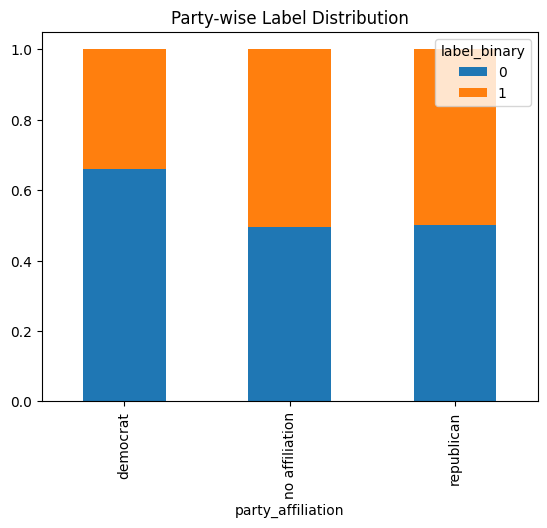

In [217]:
df.groupby('party_affiliation')['label_binary'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, title='Party-wise Label Distribution')


In [218]:
#speaker credibility ratio
df['total_hist'] = df[['barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts']].sum(axis=1)
df['fake_ratio'] = (df['half_true_counts'] + df['false_counts'] + df['pants_on_fire_counts']) / df['total_hist']
df['real_ratio'] = 1 - df['fake_ratio']

C:\Users\elena\AppData\Local\Temp\ipykernel_23820\1950592622.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['total_hist'] = df[['barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts']].sum(axis=1)
C:\Users\elena\AppData\Local\Temp\ipykernel_23820\1950592622.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fake_ratio'] = (df['half_true_counts'] + df['false_counts'] + df['pants_on_fire_counts']) / df['total_hist']
C:\Users\elena\AppData\Local\Temp

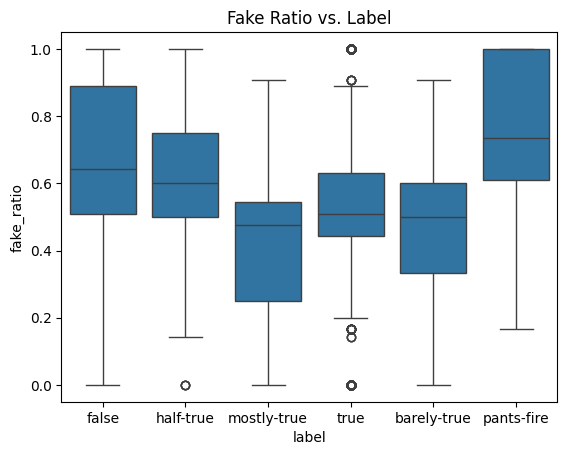

In [219]:
#box plot of fake ratio by labels
sns.boxplot(data=df, x='label', y='fake_ratio')
plt.title('Fake Ratio vs. Label')
plt.show()

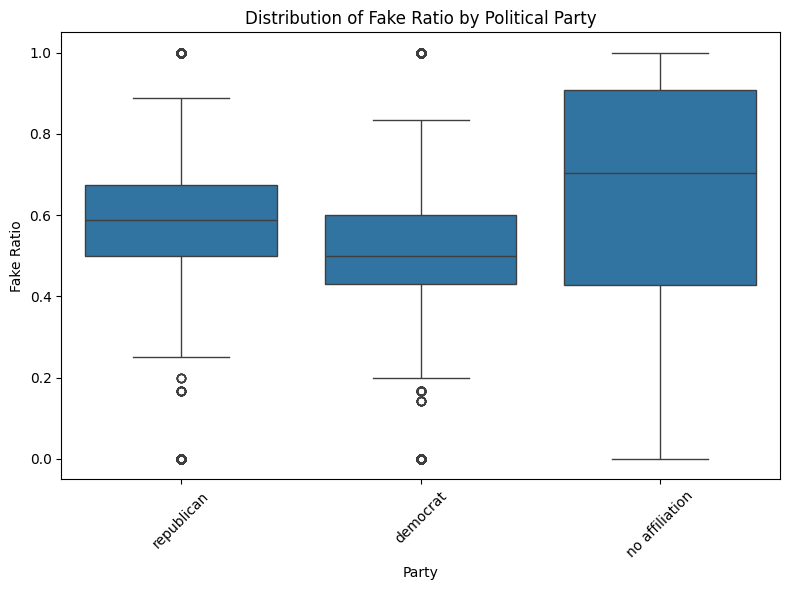

In [220]:
#box plot of fake ratio by political party

plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='party_affiliation', y='fake_ratio')
plt.title('Distribution of Fake Ratio by Political Party')
plt.xlabel('Party')
plt.ylabel('Fake Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

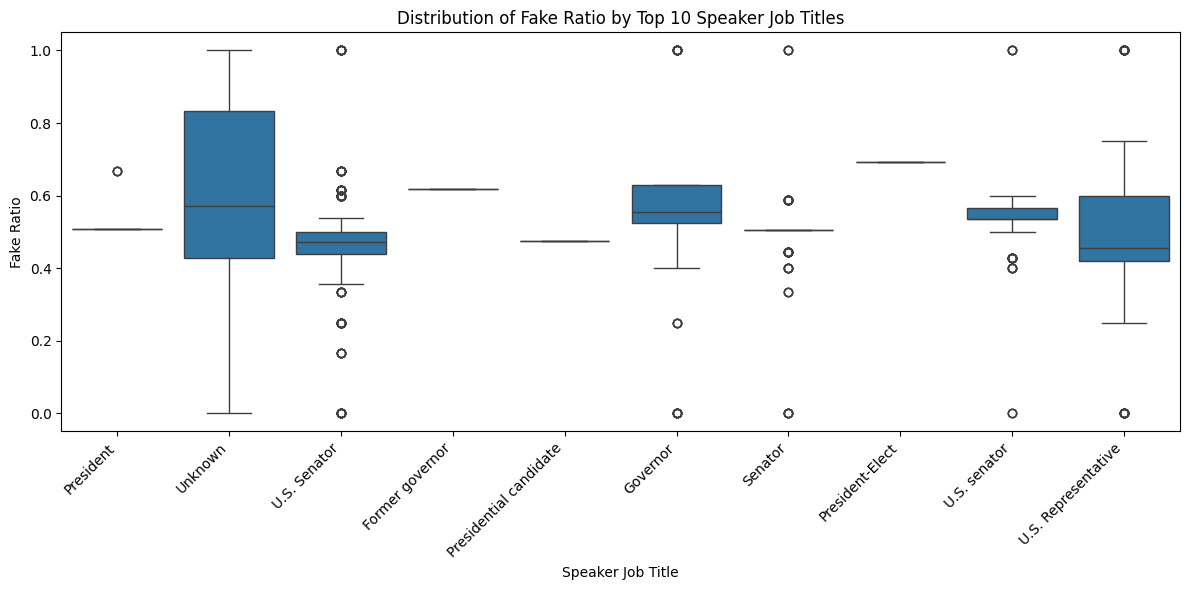

In [221]:
#box plot for fake ratio on speaker job
top_10_jobs = df['job_title'].value_counts().head(10).index
df_top_jobs = df[df['job_title'].isin(top_10_jobs)]

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_top_jobs, x='job_title', y='fake_ratio')
plt.title('Distribution of Fake Ratio by Top 10 Speaker Job Titles')
plt.xlabel('Speaker Job Title')
plt.ylabel('Fake Ratio')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Text Preprocessing

In [222]:
# tokenize, tokenize, lowercase, remove stop words
stop_words = set(stopwords.words('english'))
custom_punctuations = set(string.punctuation) | {"``", "''", "“", "”", "‘", "’", "`", "–", "—", "...", "…"}

df2=df.copy()
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)
    # Lowercase
    tokens = [token.lower() for token in tokens]
    # Remove punctuation
    tokens = [token for token in tokens if token not in string.punctuation]
    tokens=[token for token in tokens if token not in custom_punctuations]
    # Remove stop words
    tokens = [token for token in tokens if token not in stop_words]
    # Join tokens back into a single string
    return ' '.join(tokens)

df2['processed_text'] = df2['statement'].apply(preprocess_text)
df2.head()

,ID,label,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,label_binary,m_label,total_hist,fake_ratio,real_ratio,processed_text
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0,1,0,0,0,a mailer,1,2,1,1.000000,0.000000,says annies list political group supports thir...
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0,0,1,1,0,a floor speech.,0,4,2,0.500000,0.500000,decline coal start started natural gas took st...
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70,71,160,163,9,Denver,0,5,473,0.507400,0.492600,hillary clinton agrees john mccain voting give...
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,Unknown,Unknown,no affiliation,7,19,3,5,44,a news release,1,2,78,0.846154,0.153846,health care reform legislation likely mandate ...
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,Unknown,Florida,democrat,15,9,20,19,2,an interview on CNN,0,4,65,0.476923,0.523077,economic turnaround started end term


In [223]:
df2[['statement', 'processed_text']].head()

,statement,processed_text
0,Says the Annies List political group supports ...,says annies list political group supports thir...
1,When did the decline of coal start? It started...,decline coal start started natural gas took st...
2,"Hillary Clinton agrees with John McCain ""by vo...",hillary clinton agrees john mccain voting give...
3,Health care reform legislation is likely to ma...,health care reform legislation likely mandate ...
4,The economic turnaround started at the end of ...,economic turnaround started end term


In [224]:
all_words = ' '.join(df2['processed_text']).split()


word_counts = Counter(all_words)

top20=word_counts.most_common(30)
table= PrettyTable(['Word','Count'])
for word,count in top20:
    table.add_row([word,count])
print(table)

+------------+-------+
|    Word    | Count |
+------------+-------+
|    says    |  2759 |
|  percent   |  1316 |
|   state    |  905  |
|   obama    |  878  |
|    tax     |  750  |
|   health   |  720  |
|   years    |  698  |
| president  |  684  |
|   people   |  652  |
|    year    |  617  |
|    care    |  612  |
|   states   |  606  |
|   would    |  603  |
|  million   |  576  |
|    jobs    |  575  |
|    new     |  533  |
|    one     |  515  |
|    bill    |  470  |
|   texas    |  455  |
|    u.s.    |  439  |
|    said    |  437  |
|  federal   |  433  |
|  billion   |  430  |
|   barack   |  427  |
|   every    |  421  |
|   voted    |  418  |
|   taxes    |  406  |
|   since    |  404  |
|   budget   |  392  |
| government |  375  |
+------------+-------+


In [225]:
#dropping unnecessary columns
df2.drop(['ID', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'total_hist', 'fake_ratio',
        'real_ratio', 'label'], axis=1, inplace=True)

In [226]:
df2.columns

Index(['statement', 'subject', 'speaker', 'job_title', 'state_info',
       'party_affiliation', 'context', 'label_binary', 'm_label',
       'processed_text'],
      dtype='object')

Logistic Regression

In [227]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df2['processed_text'])
y = df2['label_binary']

#Data slpit
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1764, random_state=42
)

In [ ]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear', 'saga']
    }

grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy')

grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best Score:", grid.best_score_)

# Evaluate on validation set
best_lr = grid.best_estimator_
y_pred_lr = best_lr.predict(X_val)
print(classification_report(y_val, y_pred_lr))

Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.5942026205046217
              precision    recall  f1-score   support

           0       0.64      0.77      0.70       987
           1       0.60      0.45      0.51       780

    accuracy                           0.63      1767
   macro avg       0.62      0.61      0.60      1767
weighted avg       0.62      0.63      0.61      1767

